## Description:
Extracts a csv file of the specified temperature isocontour(in progress variable form) of the imported nek output.

In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml

from flamekit.datasets import SEMDataset
from flamekit.io_fronts import Case
from mpi4py import MPI
import matplotlib.pyplot as plt

from flamekit.io_fields import make_case_with_base_dir
from flamekit.io_fronts import Case, folder, front_path
from flamekit.io_fronts import load_front_csv

comm = MPI.COMM_WORLD
rank = comm.rank

### Read config file and define helper functions

In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "preprocessing/extract_isocontours" / "extract_isocontours.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

DATA_BASE_DIR = PROJECT_ROOT / Path(CFG["DATA_BASE_DIR"])
ISOCONTOUR_BASE_DIR = PROJECT_ROOT / Path(CFG["ISOCONTOUR_BASE_DIR"])
POST = bool(CFG["POST"])
FILE_NAME = str(CFG["FILE_NAME"])

PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
TIME_STEP = int(CFG["TIME_STEP"])
MULTI_TIME_STEP = bool(CFG["MULTI_TIME_STEP"])
TIME_STEP_START = int(CFG["TIME_STEP_START"])
TIME_STEP_END = int(CFG["TIME_STEP_END"])
PROGRESS_LEVELS = list(CFG["PROGRESS_LEVELS"])

SCALARS = list(CFG["SCALARS"])
COMP_VEL_JACOBIAN = bool(CFG["COMP_VEL_JACOBIAN"])
COMP_VEL_HESSIAN = bool(CFG["COMP_VEL_HESSIAN"])
COMP_REACTION_RATES = bool(CFG["COMP_REACTION_RATES"])
COMP_T_GRAD = bool(CFG["COMP_T_GRAD"])
COMP_CURV_GRAD = bool(CFG["COMP_CURV_GRAD"])
COMP_LOCAL_VEL_JACOBIAN = bool(CFG["COMP_LOCAL_VEL_JACOBIAN"])

T_REF = float(CFG["T_REF"])
P_REF = float(CFG["P_REF"])
CANTERA_YAML = PROJECT_ROOT / Path(CFG["CANTERA_YAML"])
CANTERA_INPUTS = [str(CANTERA_YAML), None, T_REF, P_REF]

def _process_one_timestep(ts: int) -> None:
    case = Case(
        base_dir=ISOCONTOUR_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )
    data_case = make_case_with_base_dir(case, DATA_BASE_DIR)
    out_case = make_case_with_base_dir(case, ISOCONTOUR_BASE_DIR)
    folder_name = folder(data_case)
    save_dir = folder(out_case)

    if rank == 0:
        save_dir.mkdir(parents=True, exist_ok=True)

    ds = SEMDataset(
        file_name=FILE_NAME,
        folder_name=folder_name,
        time_step=case.time_step,
        comm=comm,
        scalar_names=SCALARS,
    )

    df = ds.create_dataframe(
        compute_vel_jacobian=COMP_VEL_JACOBIAN,
        compute_vel_hessian=COMP_VEL_HESSIAN,
        compute_reaction_rates=COMP_REACTION_RATES,
        compute_T_grad=COMP_T_GRAD,
        compute_curv_grad=COMP_CURV_GRAD,
        compute_local_vel_jacobian=COMP_LOCAL_VEL_JACOBIAN,
        cantera_inputs=CANTERA_INPUTS,
        compute_progress_var=True,
        phi=PHI,
    )

    for iso in PROGRESS_LEVELS:
        front = ds.extract_flame_front(c_level=iso, scalar_name="progress_var")

        if rank == 0:
            out_path = front_path(out_case, float(iso))
            front.to_csv(out_path, index=False)

def _plot_one_timestep(ts: int, *, markerscale: int) -> None:
    case = Case(
        base_dir=ISOCONTOUR_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=ts,
        post=POST,
    )

    if rank != 0:
        return

    fig, ax = plt.subplots(figsize=(8, 10), dpi=150)

    for iso in PROGRESS_LEVELS:
        front = load_front_csv(case, float(iso))

        ax.scatter(
            front["x"],
            front["y"],
            s=0.01,
            alpha=1.0,
            label=fr"$c={iso}$",
        )

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(markerscale=markerscale, fontsize=8)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


### Run

In [3]:
if MULTI_TIME_STEP:
    for ts in range(TIME_STEP_START, TIME_STEP_END + 1):
        _process_one_timestep(ts)
else:
    _process_one_timestep(TIME_STEP)


2026-01-10 16:20:22,903 - Mesh - INFO - Initializing empty Mesh object.
2026-01-10 16:20:22,905 - Field - INFO - Initializing empty Field object
2026-01-10 16:20:22,906 - pynekread - INFO - Reading file: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/nek/phi0.40/h400x100_ref/po_postPremix0.f00001
2026-01-10 16:20:23,000 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2026-01-10 16:20:23,000 - Mesh - INFO - Initializing common attributes.
2026-01-10 16:20:23,002 - Mesh - INFO - Getting vertices
2026-01-10 16:20:23,008 - Mesh - INFO - Getting edge centers
2026-01-10 16:20:23,103 - Mesh - INFO - Facet centers not available for 2D
2026-01-10 16:20:23,103 - Mesh - INFO - Mesh object initialized.
2026-01-10 16:20:23,104 - Mesh - INFO - Mesh data is of type: float64
2026-01-10 16:20:23,104 - Mesh - INFO - Elapsed time: 0.1042374s
2026-01-10 16:20:23,104 - pynekread - INFO - Reading field data
2026-01-10 16:20:23,104 - pynekread - INFO - Overwriting fld obje

### Plotting

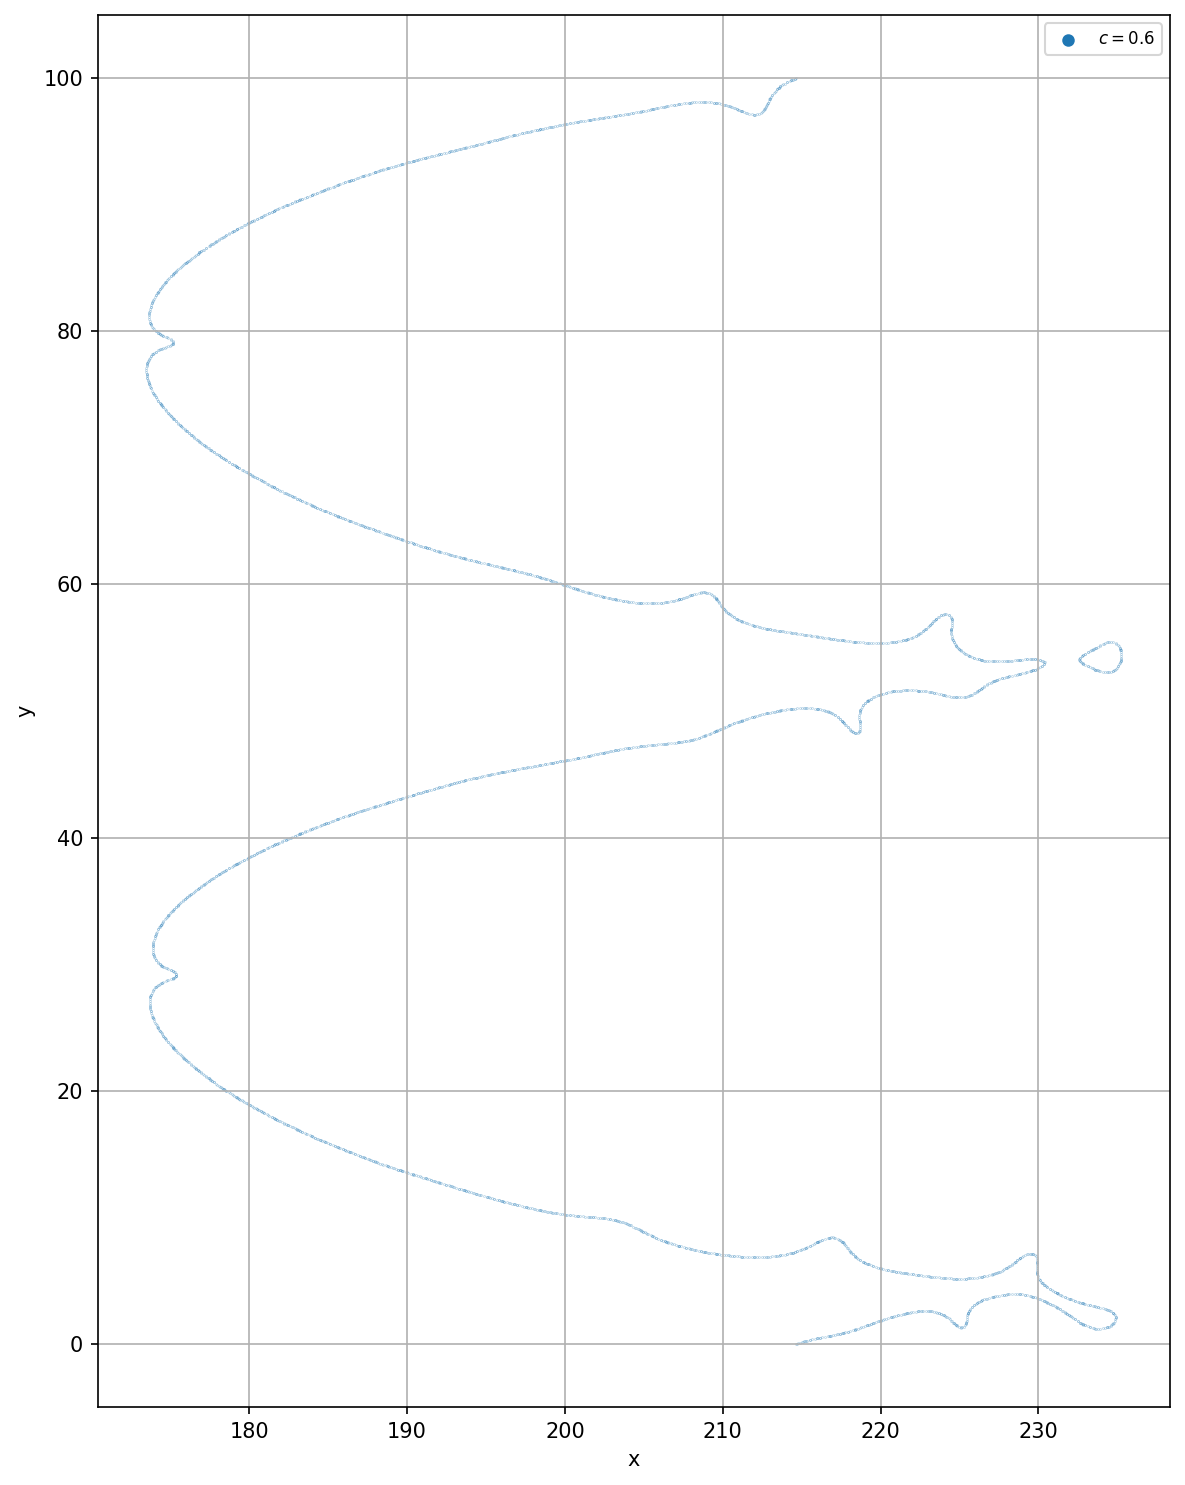

In [4]:
if MULTI_TIME_STEP:
    for ts in range(TIME_STEP_START, TIME_STEP_END + 1):
        _plot_one_timestep(ts, markerscale=50)
else:
    _plot_one_timestep(TIME_STEP, markerscale=50)
